In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import os
import random
import torchvision.models as models
import numpy as np
import pandas as pd

from tqdm import tqdm
from torch.utils.data import Dataset
from PIL import Image
from prefetch_generator import BackgroundGenerator
from torch.utils.data import DataLoader
from argparse import ArgumentParser

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
# from tensorboardX import SummaryWriter

from torchvision import transforms
import torchvision.transforms.functional as F
from typing import Sequence
from matplotlib import pyplot as plt
import itertools
import xlwt
import xlrd
from xlutils.copy import copy
from openpyxl.workbook import Workbook
from scipy.stats import norm

D:\ProgramData\Anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())
    
# 参数配置
train_folder = r'C:\Users\47872\Desktop\20240801\20240616-animal\1-human\Train'
valid_folder = r'C:\Users\47872\Desktop\20240801\20240616-animal\1-human\Valid'
batch_size = 4
pretrained = True
weight_decay = 0.0005
learning_rate = 0.001
epochs = 100
seed = 0

In [3]:
CLASSES = ['Malignant', 'Benign']

def seed_torch(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    
class Random_Rotation:
    def __init__(self, degrees=Sequence[int]):
        self.degrees = degrees

    def __call__(self, x):
        degree = random.choice(self.degrees)
        return F.rotate(x, degree)


transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    Random_Rotation([0, 90, 180, 270]),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.8)], p=0.8),
    transforms.RandomApply([transforms.ColorJitter(contrast=0.8)], p=0.8),
    transforms.RandomApply([transforms.ColorJitter(saturation=0.8, hue=0.2)], p=0.8),

    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    ),
])


transform_valid = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    ),
])


def print_conf_matrix(cm, classes):
    fig = plt.figure(figsize=(12, 6))
    plt.title('title')
    for plot_index in range(2):
        if plot_index == 1:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.subplot(1, 2, plot_index + 1)
        plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i,
                     cm[i, j] if plot_index == 0 else "{:.2f}%".format(cm[i, j] * 100),
                     horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
    
#     confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]    # 归一化
#     plt.imshow(confusion_matrix, interpolation='nearest')    # 在特定的窗口上显示图像
#     plt.title('confusion_matrix')    # 图像标题
#     plt.colorbar()
#     num_local = np.array(range(len(classes)))    
#     plt.xticks(num_local, classes, rotation=90)    # 将标签印在x轴坐标上
#     plt.yticks(num_local, classes)    # 将标签印在y轴坐标上
#     plt.ylabel('True label')    
#     plt.xlabel('Predicted label')
#     plt.show()

#     first_line = [' ']
#     first_line.extend(classes)
#     first_line = map(lambda s: s.ljust(20), first_line)

#     print(''.join(first_line))
#     all_acc = 0
#     i = 0
#     for row, _class in zip(confusion_matrix, classes):
#         row_pretty = [_class]
#         row_pretty.extend(
#             ['{:>5.2f}%({:>5.0f}/{:<5.0f})'.format(number * 100 / sum(row), number, sum(row)) for number in row])
#         row_pretty = map(lambda s: s.ljust(20), row_pretty)
#         all_acc += (row[i] / sum(row))
#         i += 1
#         print(''.join(row_pretty))
#     return all_acc / len(classes)


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(12, 6))
    plt.title(title)
    for plot_index in range(2):
        if plot_index == 1:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.subplot(1, 2, plot_index + 1)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=15)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i,
                     cm[i, j] if plot_index == 0 else "{:.2f}%".format(cm[i, j] * 100),
                     horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
    return fig
    

In [4]:
now = time.strftime("%Y_%m_%d_", time.localtime())
now

'2024_11_17_'

In [5]:
Class = {
    'Benign': 1,
    'Malignant': 0
}

seed_torch(seed=0)

# 以torch.utils.data.Dataset为基类创建MyDataset
class MyDataset(Dataset):

    def __init__(self, path, transform=None):

        self.imgs = []
#         labels = []

        for img_class in ['Benign', 'Malignant']:

            if not os.path.exists(os.path.join(path, img_class)):
                print("Path not exists!")
            else:
                imgs = glob.glob(os.path.join(path, img_class) + '/*.jpg')
                for img in imgs:
                    self.imgs.append((img, Class[img_class]))

        #       self.labels = self.labels.append(img_class)
        #       self.imgs = imgs
                    
        random.shuffle(self.imgs)
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.imgs[index]
#         label = self.Class[index]
        image = Image.open(img).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.imgs)

In [6]:
train_dataset = MyDataset(train_folder, transform=transform_train)
valid_dataset = MyDataset(valid_folder, transform=transform_valid)

train_loader = DataLoaderX(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)
valid_loader = DataLoaderX(valid_dataset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)

len(valid_loader)

933

In [7]:
#  for images, labels in train_loader:
#         for i in range(4):
#             # [C, H, W] -> [H, W, C]
#             img = images[i].numpy().transpose(1, 2, 0)
#             label = labels[i]
#             # 反Normalize操作
#             img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
#             plt.subplot(1, 4, i + 1)
#             plt.title(label)
#             # plt.xticks([])  # 去掉x轴的刻度
#             # plt.yticks([])  # 去掉y轴的刻度
#             plt.imshow(img.astype('uint8'))
#         plt.show()

In [8]:
if torch.cuda.is_available():
    print("True")
    device = torch.device("cuda:0")

True


In [9]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        keep_features = list()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        keep_features.append(x)
        x = self.layer2(x)
        keep_features.append(x)
        x = self.layer3(x)
        keep_features.append(x)
        x = self.layer4(x)
        keep_features.append(x)
        
        global_features = list()
        for i, features in enumerate(keep_features):
            features = nn.AdaptiveAvgPool2d(7)(features)
            global_features.append(features)
        
        x = torch.cat(global_features, 1)
#         x = nn.Conv2d(in_channels=3840, out_channels=2048,kernel_size=(1, 1), stride=(1, 1))(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)

def resnet152(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes, include_top=include_top)


In [10]:
def create_model(model_name, pretrained):

    global model

    if model_name == 'vgg19':
        model = models.vgg19(pretrained=pretrained)
        n_inputs = model.classifier[6].in_features
        last_layer = nn.Linear(n_inputs, 2)
        model.classifier[6] = last_layer

    if model_name == 'Densenet-161':
        model = models.densenet161(pretrained=pretrained)
        n_inputs = model.classifier.in_features
        last_layer = nn.Linear(n_inputs, 2)
        model.classifier = last_layer

    if model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=pretrained)
        n_inputs = model.classifier[1].in_features
        last_layer = nn.Linear(n_inputs, 2)
        model.classifier[1] = last_layer

    if model_name == 'local':
#         model = models.resnet152(pretrained = pretrained)
        model = resnet152(1000, True)
        n_inputs = model.fc.in_features
        last_layer = nn.Linear(3840, 2)
#         last_layer = nn.Linear(2048, 2)
        model.fc = last_layer
        checkpoint = torch.load('./checkpoint.pth')
        
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        

    return model

In [11]:
model = create_model('vgg19', pretrained)
# model = model.to(device)
model.to(device)

D:\ProgramData\Anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\ProgramData\Anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
criterion = nn.CrossEntropyLoss()

    # optimizer

optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=weight_decay, nesterov=True)

# optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, betas=(0.9, 0.99), eps=1e-8, weight_decay=args.weight_decay)  # Adam梯度下降

# optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate, betas=(0.9, 0.99), eps=1e-8, weight_decay=args.weight_decay)  # Adam梯度下降



# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



In [13]:
def AUC_CI(auc, label, alpha = 0.05):
	label = np.array(label)#防止label不是array类型
	n1, n2 = np.sum(label == 1), np.sum(label == 0)
	q1 = auc / (2-auc)
	q2 = (2 * auc ** 2) / (1 + auc)
	se = np.sqrt((auc * (1 - auc) + (n1 - 1) * (q1 - auc ** 2) + (n2 -1) * (q2 - auc ** 2)) / (n1 * n2))
	confidence_level = 1 - alpha
	z_lower, z_upper = norm.interval(confidence_level)
	lowerb, upperb = auc + z_lower * se, auc + z_upper * se
	return (lowerb, upperb)


In [14]:
def print_roc(fpr, tpr, Auc, CI, method):
    
#     plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(Auc), lw=2)
    
    label = '{}(Auc = {} ({}-{}))'.format(str(method), round(Auc, 3), round(CI[0], 3), round(CI[1], 3))
#     plt.plot(fpr, tpr, color='blue', lw=2, label='95%CI AUC(area = {})'.format(round(Auc, 3)))
    plt.plot(fpr, tpr, color='blue', lw=2, label=label)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
 
    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [15]:
def run(model, dataloader, phase, device, criterion, optimizer, epoch):
    
    if phase == 'train':
        model.train()
    elif phase == 'valid':
        model.eval()
    else:
        raise Exception("Error occurs")

    run_loss = 0.0

    label_lists = np.array([])
    predict_lists = np.array([])
    value_lists = np.array([])


    for i, (inputs, labels) in tqdm(enumerate(dataloader)):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            value = outputs[:, 1]
            _loss = criterion(outputs, labels)

                # update model and optimizer
            if phase == 'train':
                _loss.backward()
            optimizer.step()

            # update train/valid diagnostics
        run_loss += _loss.item() * inputs.size(0)

        label_lists = np.concatenate((label_lists, labels.cpu().numpy()))
        predict_lists = np.concatenate((predict_lists, preds.cpu().numpy()))
        value_lists = np.concatenate((value_lists, value.detach().cpu().numpy()))



    # print all diagnostics
    Loss = run_loss / (len(label_lists))
    Acc1 = (label_lists == predict_lists).sum()
    Acc2 = len(predict_lists)
    Acc = Acc1 / Acc2
    TP = ((predict_lists == 1) & (label_lists == 1)).sum()
    TN = ((predict_lists == 0) & (label_lists == 0)).sum()
    FN = ((predict_lists == 0) & (label_lists == 1)).sum()
    FP = ((predict_lists == 1) & (label_lists == 0)).sum()

    p = TP / (TP + FP)
    r = TP / (TP + FN)
    F1 = 2 * r * p / (r + p)

    conf_matrix = confusion_matrix(label_lists, predict_lists, labels=list(range(2)))
    fpr, tpr, theshold = roc_curve(label_lists, value_lists, pos_label=1)
    Auc = auc(fpr, tpr)
    
    CI = AUC_CI(Auc, label_lists, 0.05)
    
    if epoch==100:
        if phase == 'train':
            FPR = pd.DataFrame(fpr)
            writer1 = pd.ExcelWriter('test1.xlsx', engine='openpyxl', mode='a')
            FPR.to_excel(writer1, 'page_1' + str(epoch), float_format='%.5f')
            writer1._save()

            TPR = pd.DataFrame(tpr)
            writer2 = pd.ExcelWriter('test2.xlsx', engine='openpyxl', mode='a')
            TPR.to_excel(writer2, 'page_1' + str(epoch), float_format='%.5f')
            writer2._save()
        else:
            FPR = pd.DataFrame(fpr)
            writer1 = pd.ExcelWriter('test1.xlsx', engine='openpyxl', mode='a')
            FPR.to_excel(writer1, 'page_' + str(epoch), float_format='%.5f')
            writer1._save()

            TPR = pd.DataFrame(tpr)
            writer2 = pd.ExcelWriter('test2.xlsx', engine='openpyxl', mode='a')
            TPR.to_excel(writer2, 'page_' + str(epoch), float_format='%.5f')
            writer2._save()
    
    method = 'vgg19'
    print_roc(fpr, tpr, Auc, CI, method)
    print_conf_matrix(conf_matrix, CLASSES)

    print("%s confusion matrix:" % phase.capitalize())
    print('AUC', auc(fpr, tpr))

#     Writer = SummaryWriter()

#     Writer.add_scalar('%s/Loss' % phase.capitalize(), Loss, Epoch)
#     Writer.add_scalar('%s/Acc' % phase.capitalize(), Acc, Epoch)
#     Writer.add_scalar('{}/AUC'.format(phase.capitalize()), auc(fpr, tpr), Epoch)
#     Writer.add_scalar('%s/EBV_Precision' % phase.capitalize(), p, Epoch)
#     Writer.add_scalar('%s/EBV_Recall' % phase.capitalize(), r, Epoch)
#     Writer.add_scalar('%s/EBV_F1' % phase.capitalize(), F1, Epoch)
#     Writer.add_figure('{}[{}]'.format(phase.capitalize(), Epoch), figure=plot_confusion_matrix(
#         conf_matrix, classes=CLASSES, title='Confusion Matrix'), global_step=Epoch)

    return Loss, p, r, F1, Acc, auc(fpr, tpr), conf_matrix


class DataPrefetcher:

    def __init__(self, loader):
        self.next_target = None
        self.next_input = None
        self.input_cuda = self._input_cuda_for_image
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.record_stream = DataPrefetcher._record_stream_for_image
        self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.input_cuda()
            self.next_target = torch.tensor(self.next_target).cuda(non_blocking=True)

    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input_ = self.next_input
        target = self.next_target
        if input_ is not None:
            self.record_stream(input_)
        if target is not None:
            target.record_stream(torch.cuda.current_stream())
        self.preload()
        return input_, target

    def _input_cuda_for_image(self):
        self.next_input = torch.tensor(self.next_input).cuda(non_blocking=True)

    @staticmethod
    def _record_stream_for_image(input):
        input.record_stream(torch.cuda.current_stream())

In [16]:
def write_to_excel(result, path):
    
    workbook = xlrd.open_workbook(path)
    worksheet = workbook.sheet_by_name(workbook.sheet_names()[0])
    rows = worksheet.nrows

    new_workbook = copy(workbook)
    new_worksheet = new_workbook.get_sheet(0)

    for i in range(0,len(result)):
        new_worksheet.write(rows, i, result[i])
    new_workbook.save(path)


In [17]:
def start_train(train_loader, valid_loader, model, device, criterion, optimizer, scheduler, epochs):
    best_F1 = 0.0
    best_auc = 0.0
    lowest_loss = 100000

    for epoch in range(1, epochs + 1):

        global Epoch
        Epoch = epoch

        print('\nEpoch [{}/{}]'.format(epoch, epochs))

        print('\n Train ')

        train_loss, t_p, t_r, t_F1, train_acc, train_auc, train_cm = run(model, train_loader, 'train', device, criterion, optimizer, epoch)
        print('\n Valid ')
        valid_loss, v_p, v_r, v_F1, valid_acc, valid_auc, valid_cm = run(model, valid_loader, 'valid', device, criterion, optimizer, epoch)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print('Epoch {} with lr {:.15f}: t_loss: {:.4f} t_acc: {:.4f} v_loss:{:.4f} v_acc: {:.4f}\n'.format(epoch, current_lr, train_loss, train_acc, valid_loss, valid_acc))
        print('LYnode: t_precision: {:.4f}, t_recall: {:.4f}, t_F1: {:.4f}'.format(t_p, t_r, t_F1))
        print('LYnode: v_precision: {:.4f}, v_recall: {:.4f}, v_F1: {:.4f}'.format(v_p, v_r, v_F1))
        
        result = list()
        result.extend([train_auc,valid_auc,train_loss,train_acc,valid_loss,valid_acc,t_p,t_r,t_F1,v_p,v_r, v_F1])
        path = './vgg19.xlsx'
        write_to_excel(result, path)

#         checkpoints_path = './model/'
#         if v_F1 > best_F1:
#             best_F1 = v_F1
#             torch.save(model.state_dict(), os.path.join(
#                 checkpoints_path, 'bestF1.pth')
#                        )
#         if valid_loss < lowest_loss:
#             lowest_loss = valid_loss
#             torch.save(model.state_dict(), os.path.join(
#                 checkpoints_path, 'bestloss.pth')
#                        )
#         if valid_auc > best_auc:
#             best_auc = valid_auc
#             torch.save(model.state_dict(), os.path.join(
#                 checkpoints_path, 'bestauc.pth')
#                        )
    torch.save(model.state_dict(), os.path.join(
        './model/final/', 'FINAL.pth')
               )


Epoch [1/100]

 Train 


3153it [07:51,  6.68it/s]


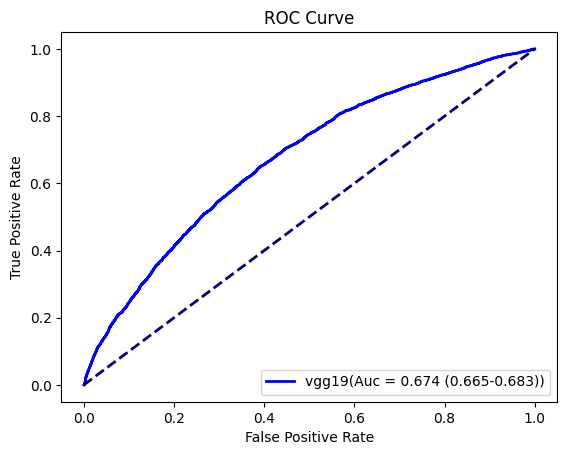

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


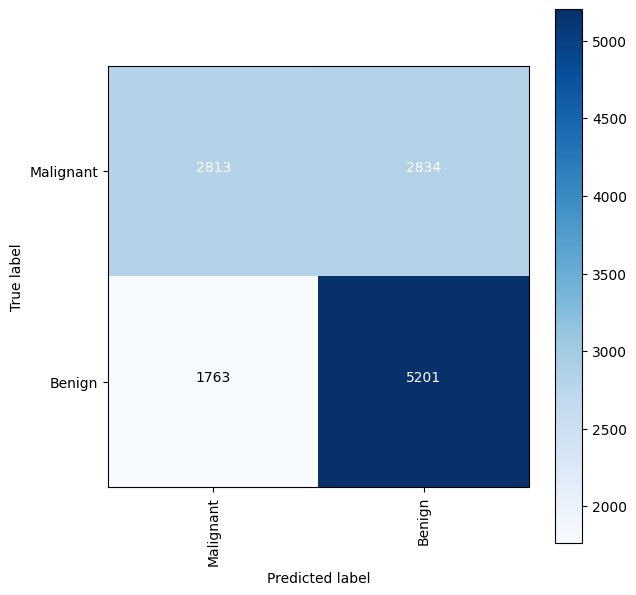

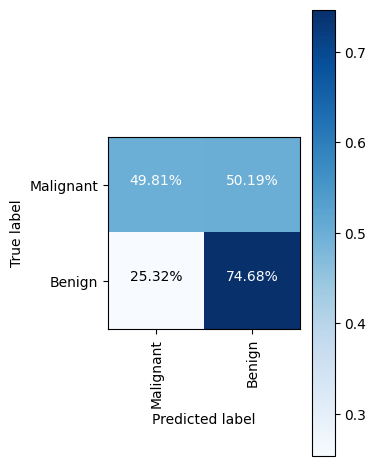

Train confusion matrix:
AUC 0.6739592329780814

 Valid 


933it [01:19, 11.69it/s]


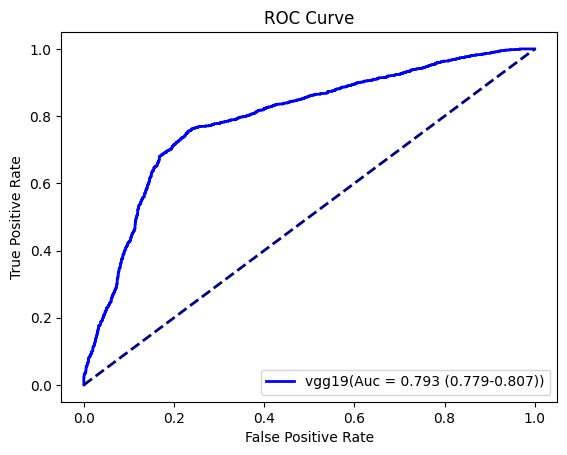

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


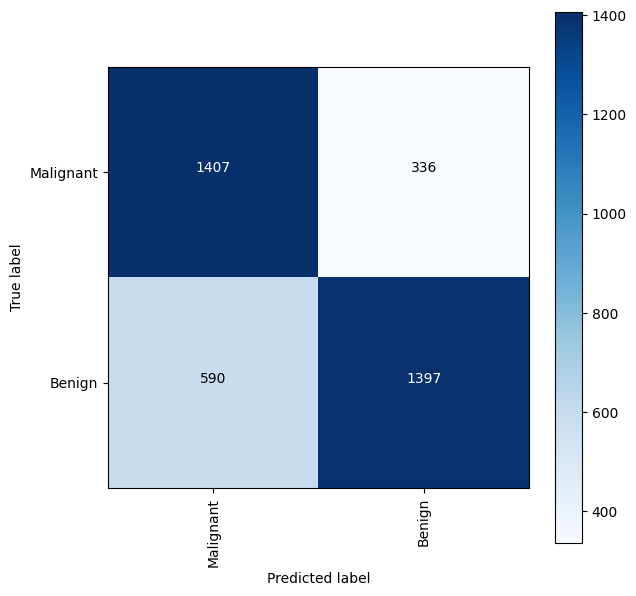

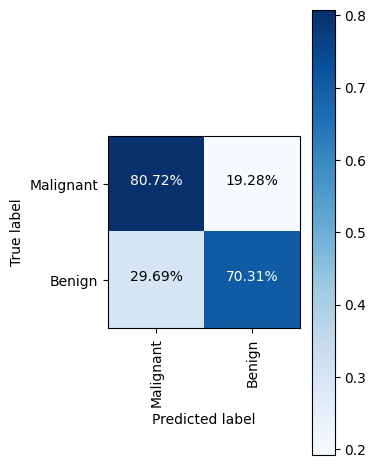

Valid confusion matrix:
AUC 0.7929551262783537
Epoch 1 with lr 0.001000000000000: t_loss: 0.6444 t_acc: 0.6355 v_loss:0.5579 v_acc: 0.7517

LYnode: t_precision: 0.6473, t_recall: 0.7468, t_F1: 0.6935
LYnode: v_precision: 0.8061, v_recall: 0.7031, v_F1: 0.7511

Epoch [2/100]

 Train 


3153it [10:38,  4.94it/s]


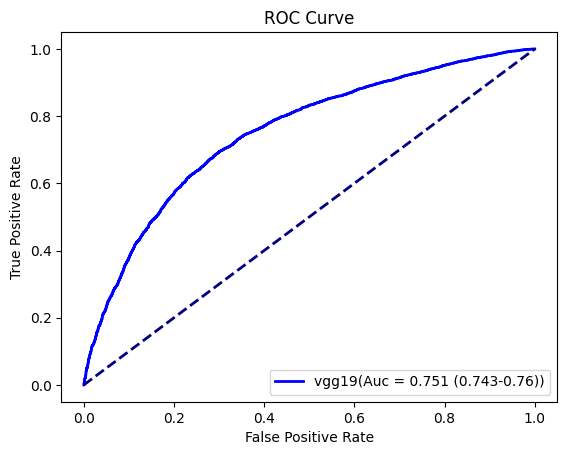

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


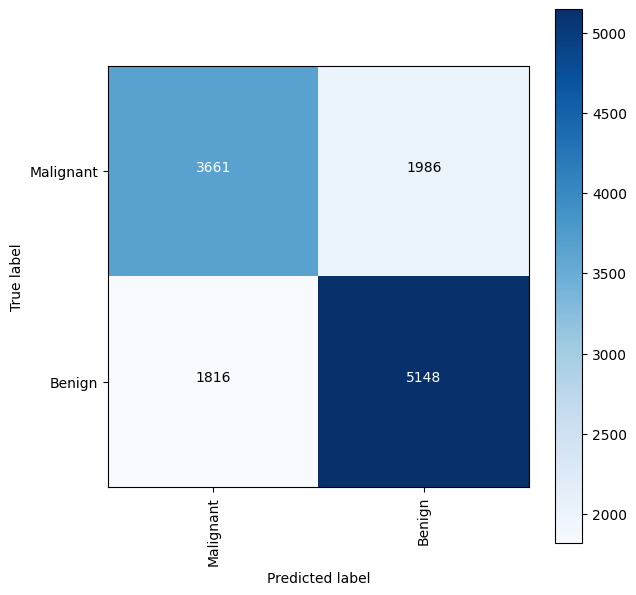

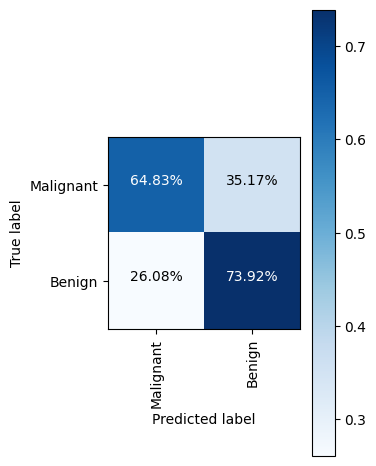

Train confusion matrix:
AUC 0.7514139224143148

 Valid 


933it [01:37,  9.58it/s]


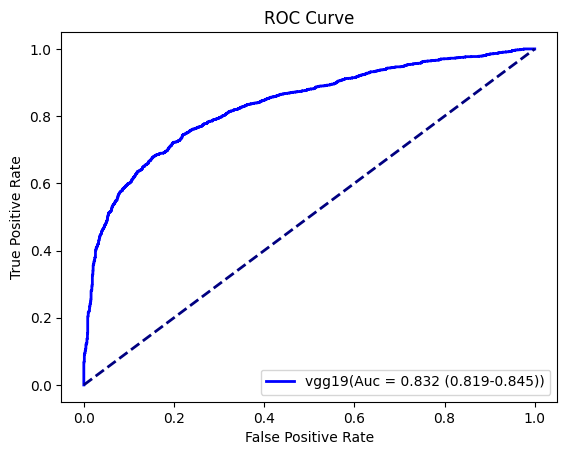

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


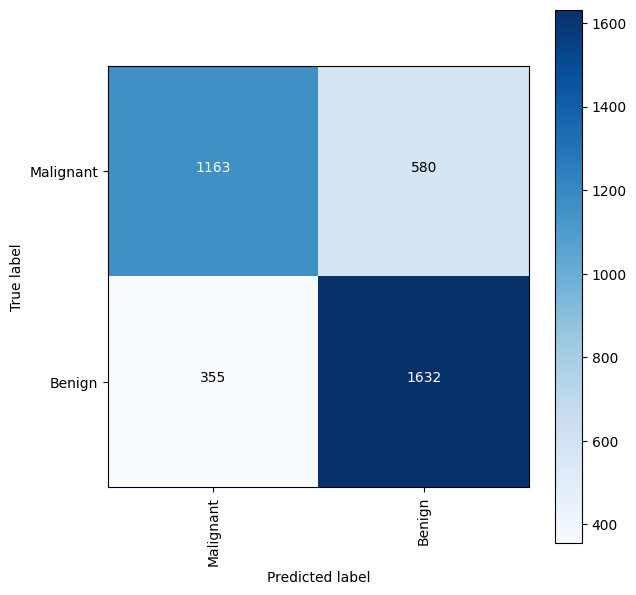

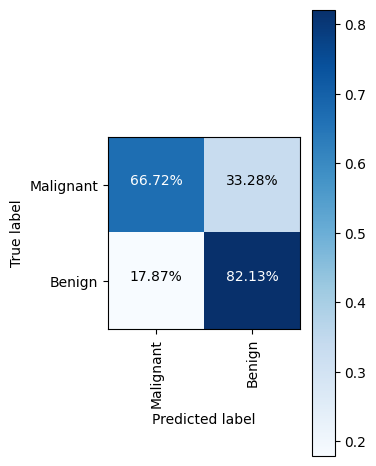

Valid confusion matrix:
AUC 0.8323624500157507
Epoch 2 with lr 0.001000000000000: t_loss: 0.5883 t_acc: 0.6985 v_loss:0.5439 v_acc: 0.7493

LYnode: t_precision: 0.7216, t_recall: 0.7392, t_F1: 0.7303
LYnode: v_precision: 0.7378, v_recall: 0.8213, v_F1: 0.7773

Epoch [3/100]

 Train 


3153it [10:53,  4.83it/s]


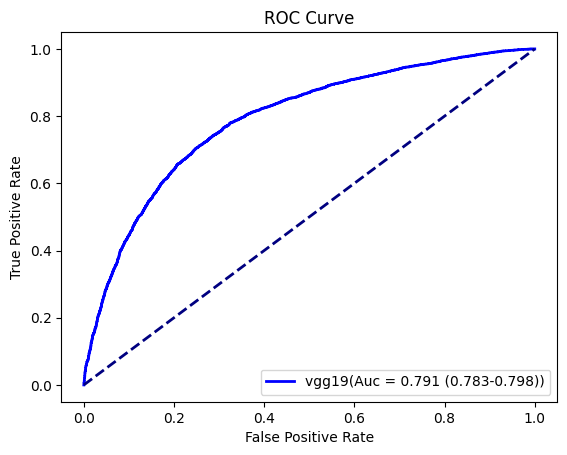

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


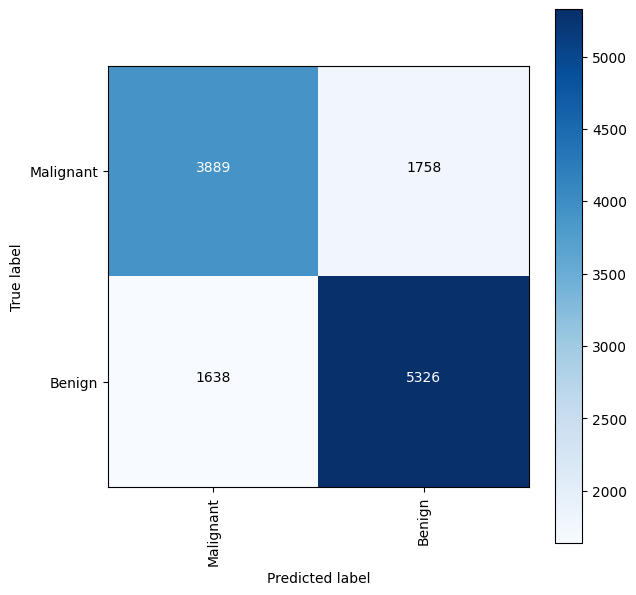

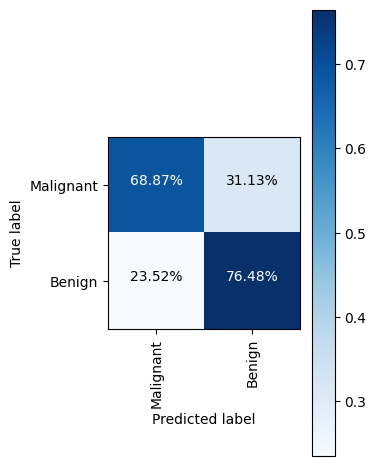

Train confusion matrix:
AUC 0.79063317817444

 Valid 


933it [01:40,  9.30it/s]


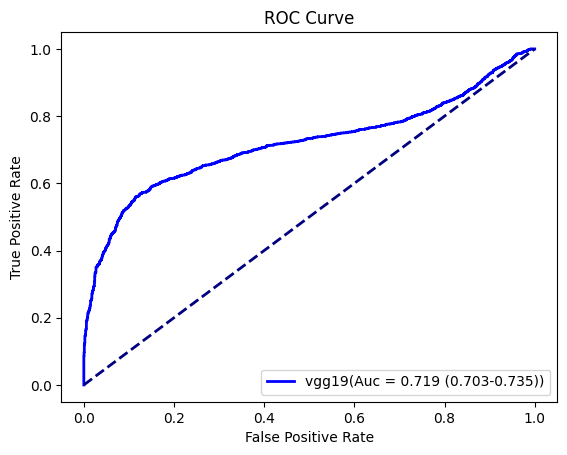

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


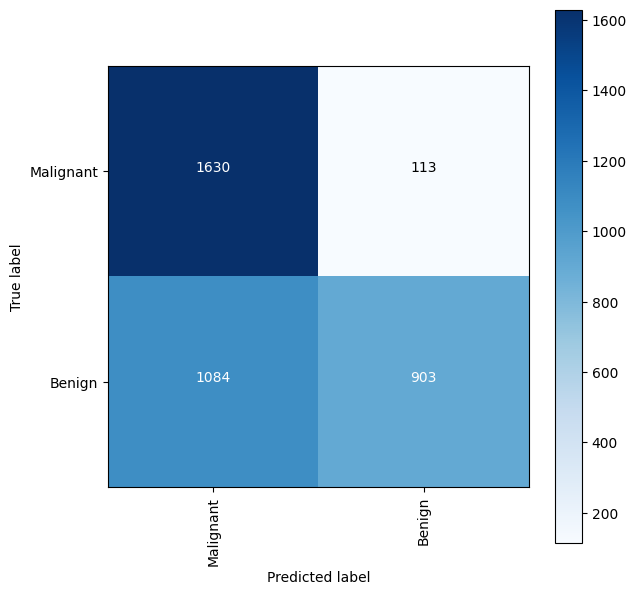

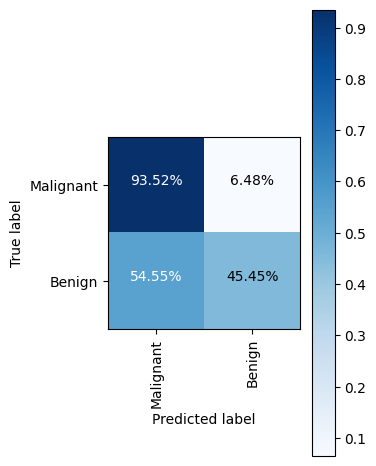

Valid confusion matrix:
AUC 0.7186985052872357
Epoch 3 with lr 0.001000000000000: t_loss: 0.5507 t_acc: 0.7307 v_loss:0.7561 v_acc: 0.6791

LYnode: t_precision: 0.7518, t_recall: 0.7648, t_F1: 0.7583
LYnode: v_precision: 0.8888, v_recall: 0.4545, v_F1: 0.6014

Epoch [4/100]

 Train 


3153it [10:41,  4.92it/s]


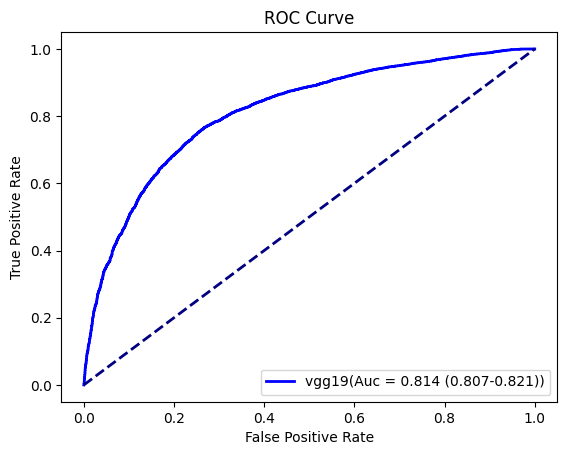

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


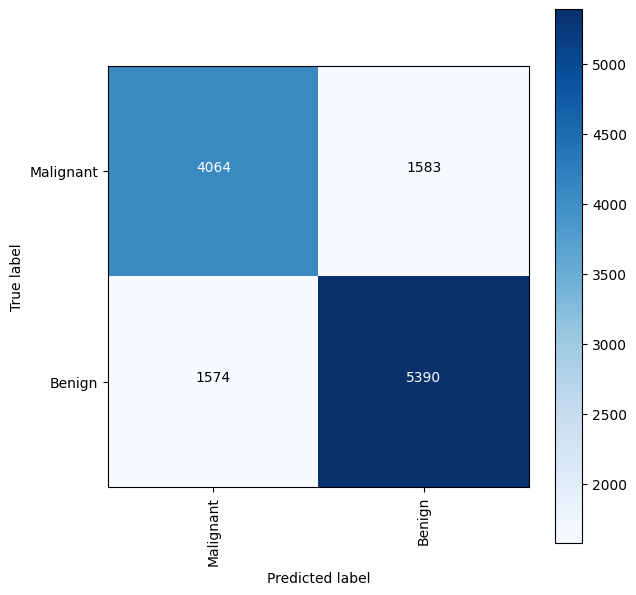

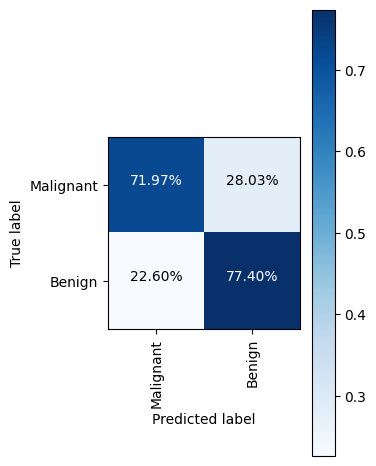

Train confusion matrix:
AUC 0.8140546382534295

 Valid 


933it [01:39,  9.41it/s]


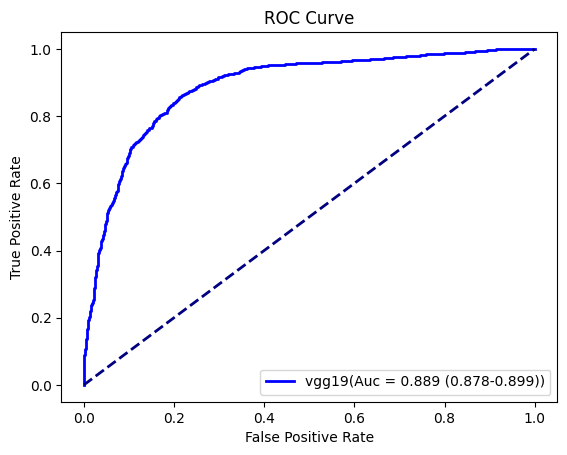

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


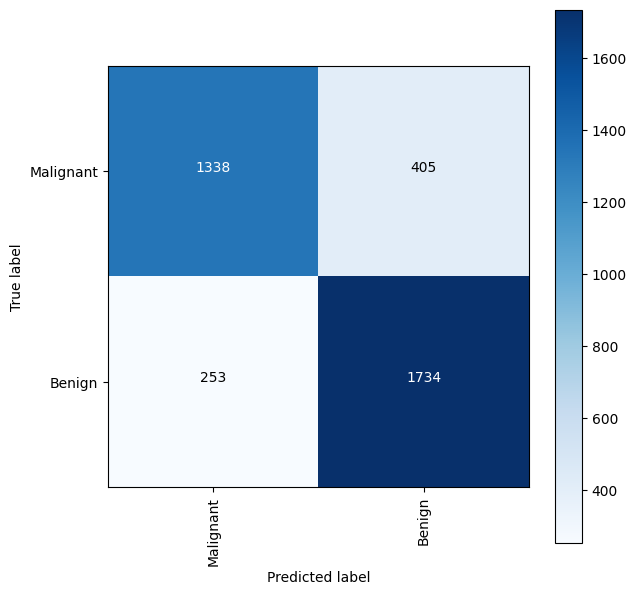

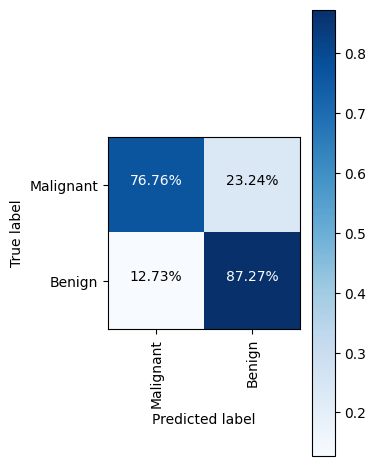

Valid confusion matrix:
AUC 0.8889087156014956
Epoch 4 with lr 0.001000000000000: t_loss: 0.5250 t_acc: 0.7497 v_loss:0.4334 v_acc: 0.8236

LYnode: t_precision: 0.7730, t_recall: 0.7740, t_F1: 0.7735
LYnode: v_precision: 0.8107, v_recall: 0.8727, v_F1: 0.8405

Epoch [5/100]

 Train 


3153it [10:46,  4.87it/s]


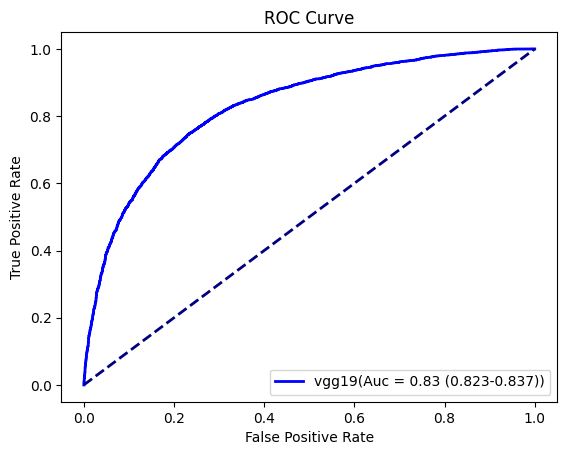

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


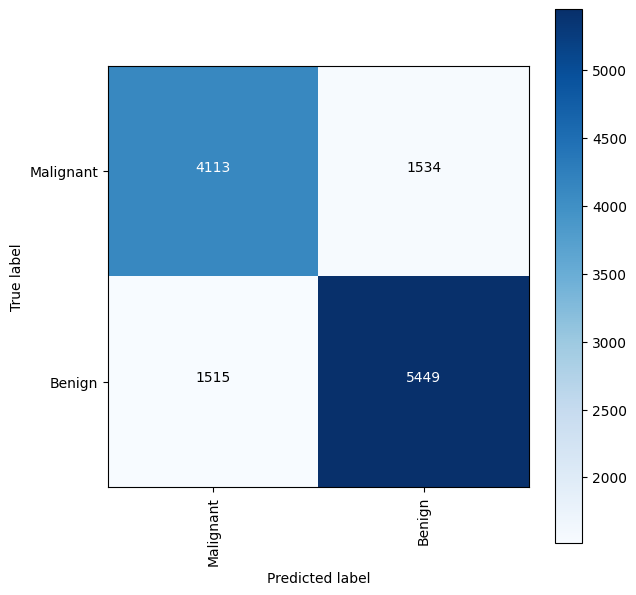

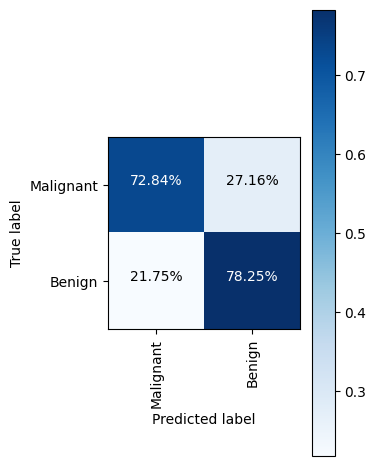

Train confusion matrix:
AUC 0.8295291721130614

 Valid 


933it [01:36,  9.70it/s]


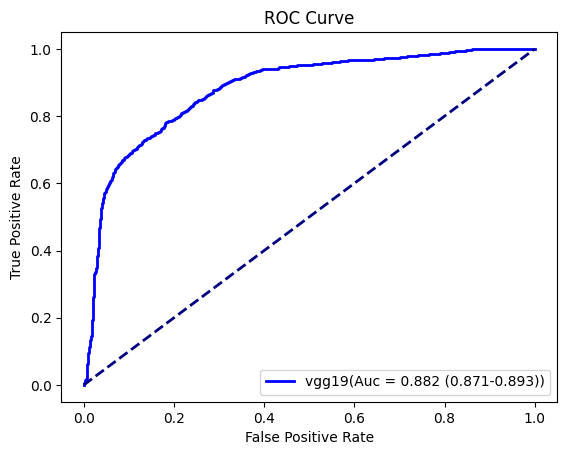

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


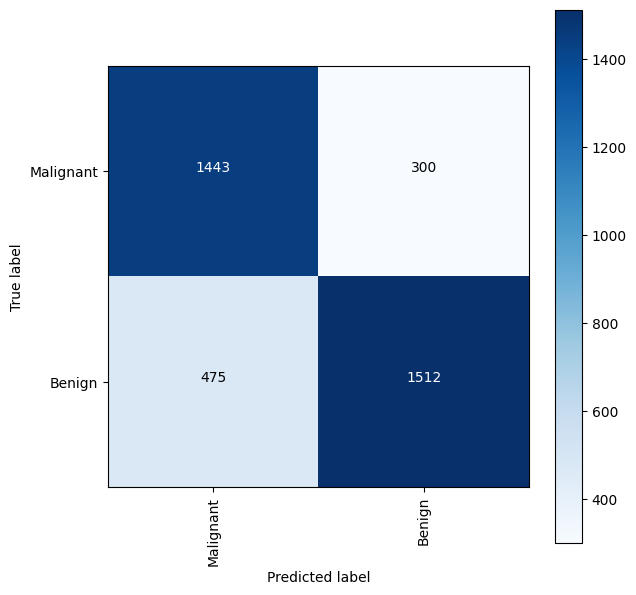

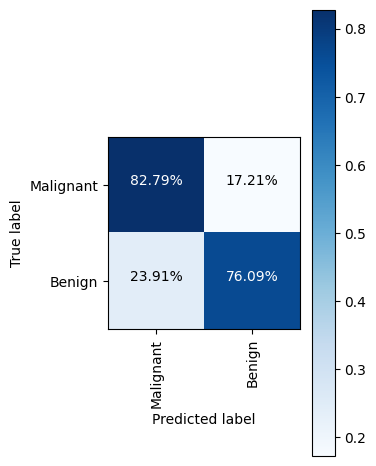

Valid confusion matrix:
AUC 0.8820038223207012
Epoch 5 with lr 0.001000000000000: t_loss: 0.5055 t_acc: 0.7582 v_loss:0.4412 v_acc: 0.7922

LYnode: t_precision: 0.7803, t_recall: 0.7825, t_F1: 0.7814
LYnode: v_precision: 0.8344, v_recall: 0.7609, v_F1: 0.7960

Epoch [6/100]

 Train 


3153it [10:18,  5.10it/s]


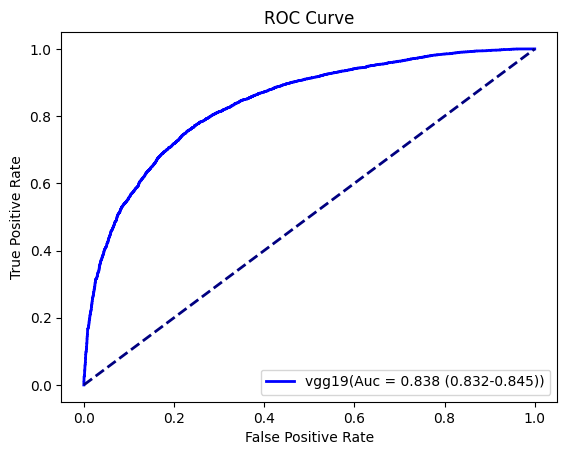

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


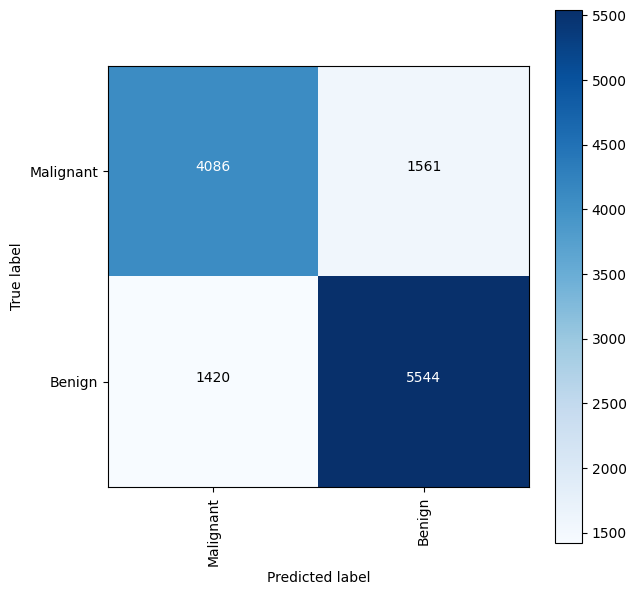

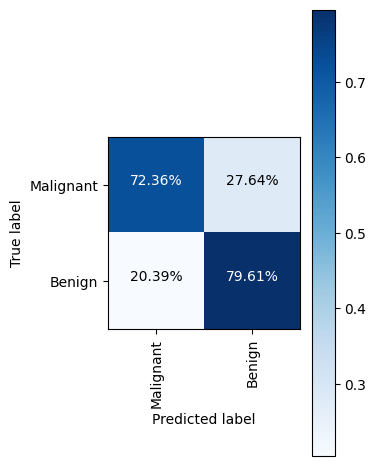

Train confusion matrix:
AUC 0.8383564003475793

 Valid 


933it [01:35,  9.76it/s]


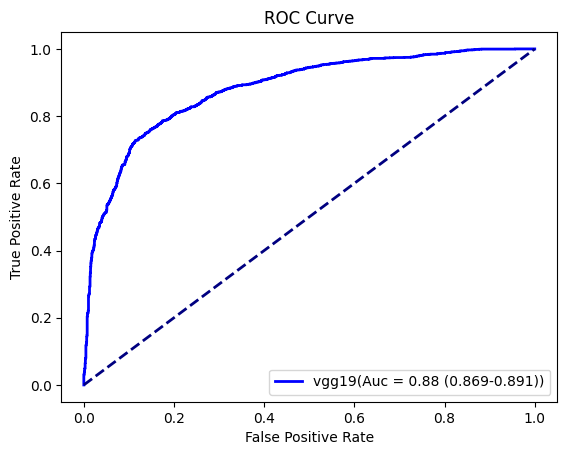

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


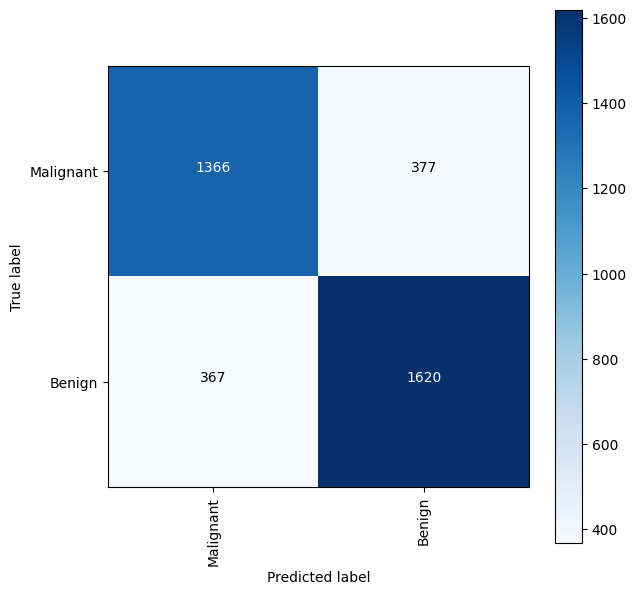

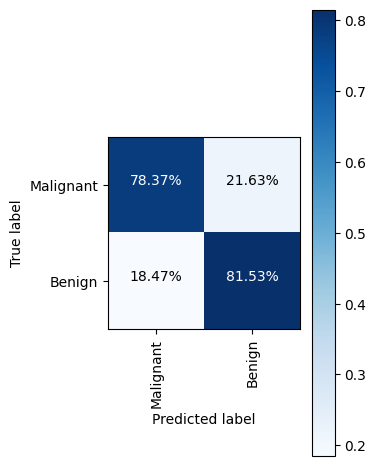

Valid confusion matrix:
AUC 0.880455317567632
Epoch 6 with lr 0.001000000000000: t_loss: 0.4930 t_acc: 0.7636 v_loss:0.4358 v_acc: 0.8005

LYnode: t_precision: 0.7803, t_recall: 0.7961, t_F1: 0.7881
LYnode: v_precision: 0.8112, v_recall: 0.8153, v_F1: 0.8133

Epoch [7/100]

 Train 


3153it [10:24,  5.05it/s]


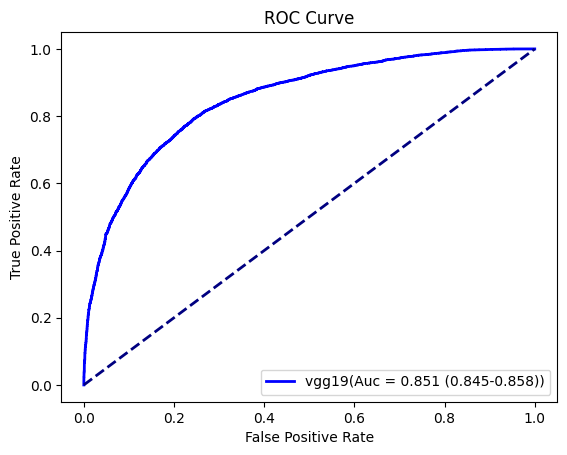

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


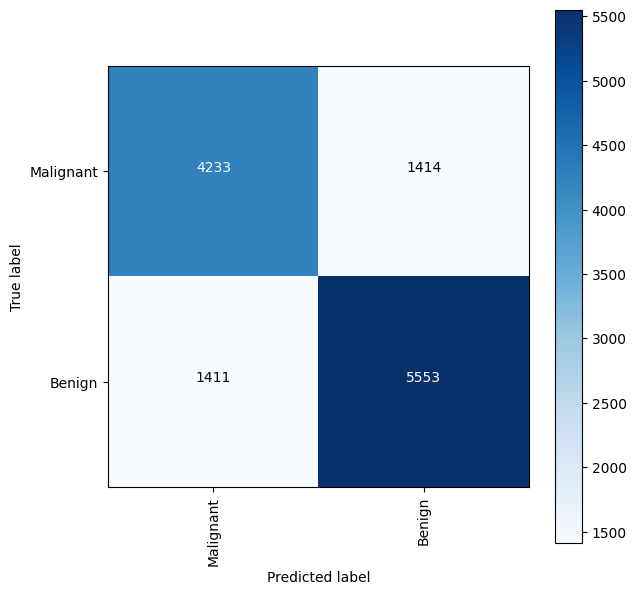

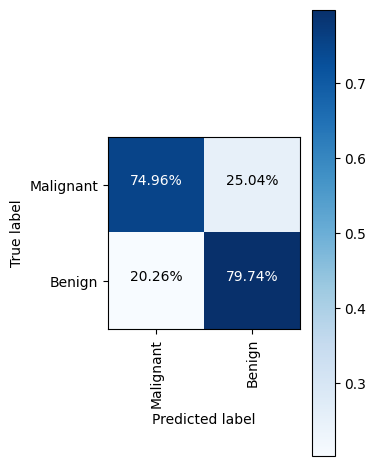

Train confusion matrix:
AUC 0.8514994567929965

 Valid 


933it [01:35,  9.75it/s]


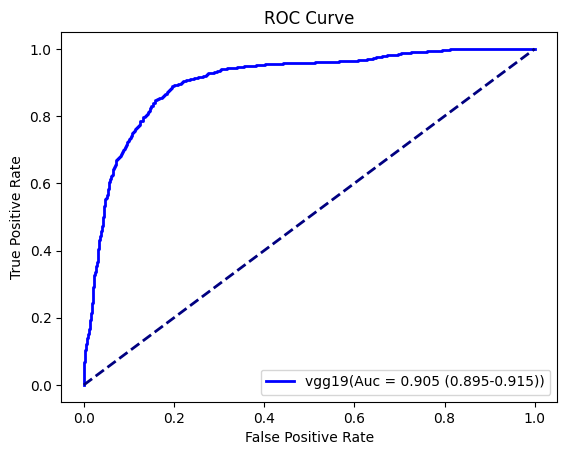

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


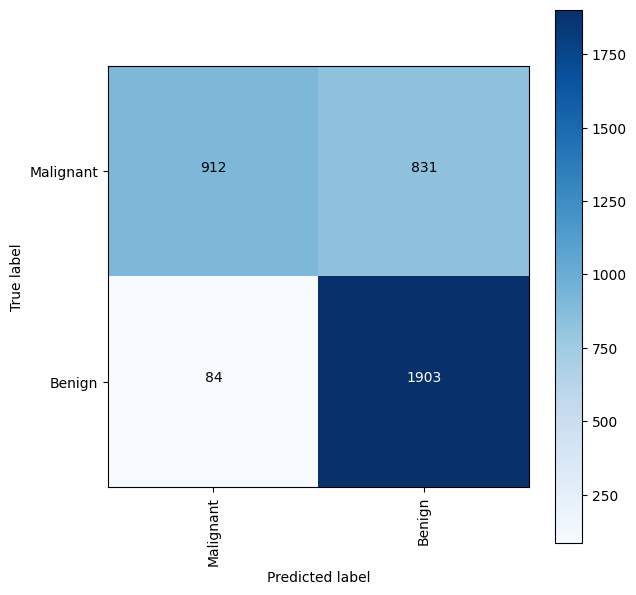

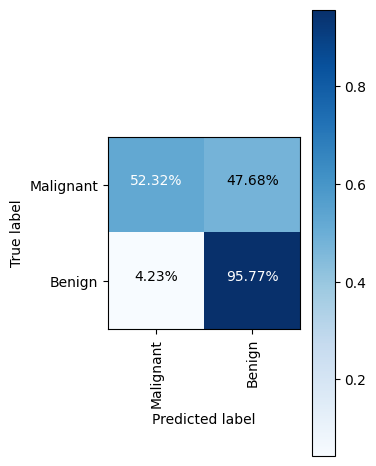

Valid confusion matrix:
AUC 0.9048999217807314
Epoch 7 with lr 0.001000000000000: t_loss: 0.4738 t_acc: 0.7760 v_loss:0.4746 v_acc: 0.7547

LYnode: t_precision: 0.7970, t_recall: 0.7974, t_F1: 0.7972
LYnode: v_precision: 0.6960, v_recall: 0.9577, v_F1: 0.8062

Epoch [8/100]

 Train 


3153it [10:37,  4.95it/s]


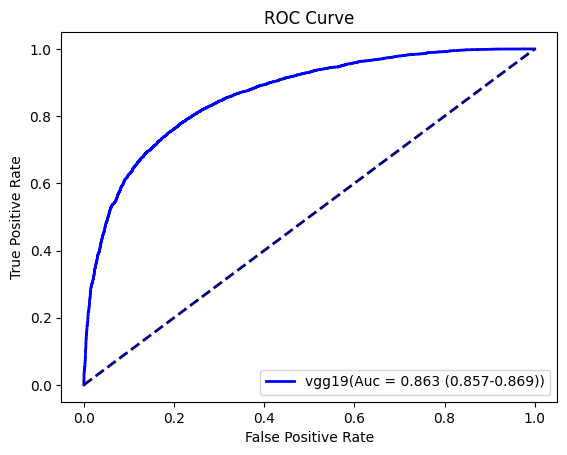

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


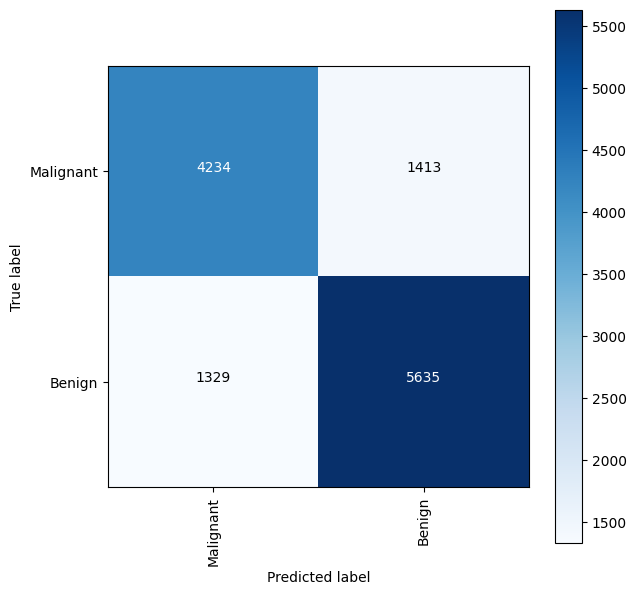

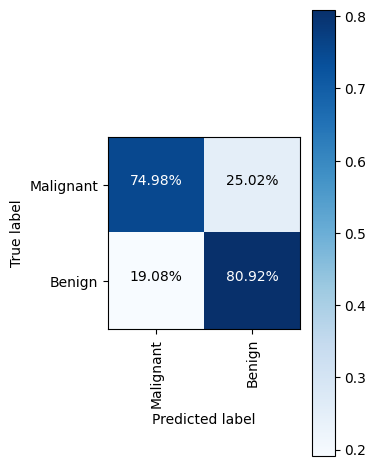

Train confusion matrix:
AUC 0.8629516854470872

 Valid 


933it [01:36,  9.68it/s]


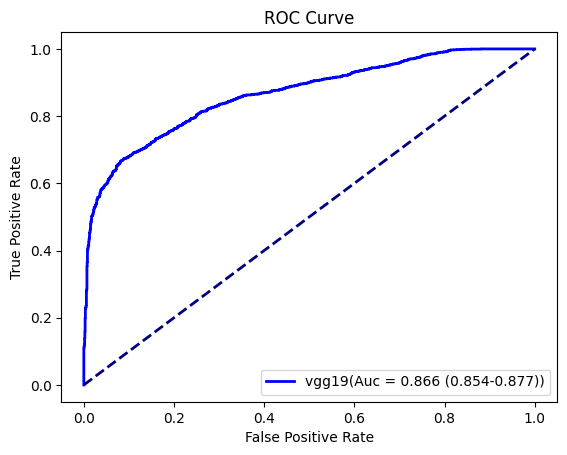

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


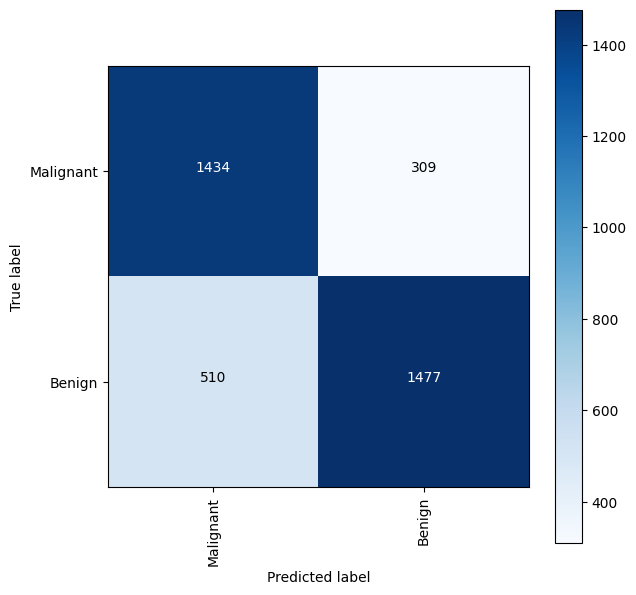

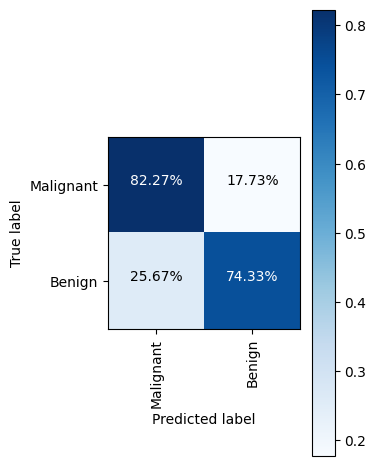

Valid confusion matrix:
AUC 0.8658979869438209
Epoch 8 with lr 0.001000000000000: t_loss: 0.4571 t_acc: 0.7826 v_loss:0.4564 v_acc: 0.7804

LYnode: t_precision: 0.7995, t_recall: 0.8092, t_F1: 0.8043
LYnode: v_precision: 0.8270, v_recall: 0.7433, v_F1: 0.7829

Epoch [9/100]

 Train 


3153it [10:39,  4.93it/s]


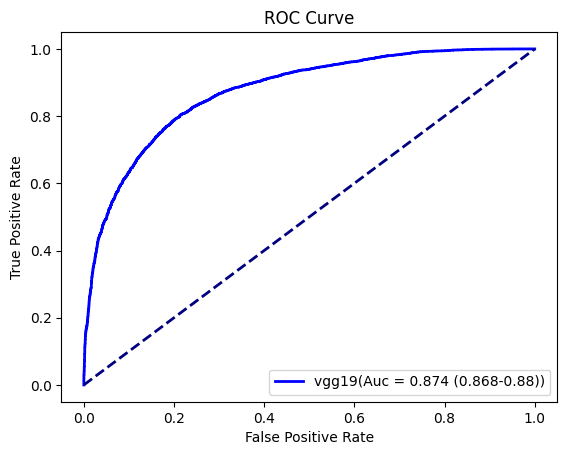

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


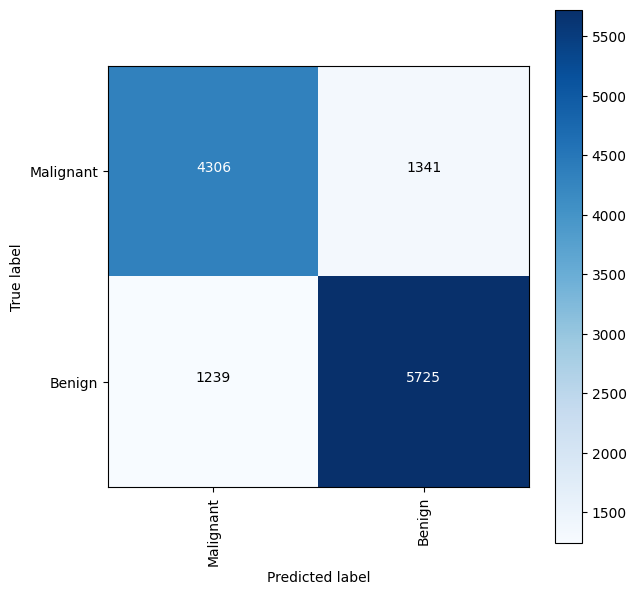

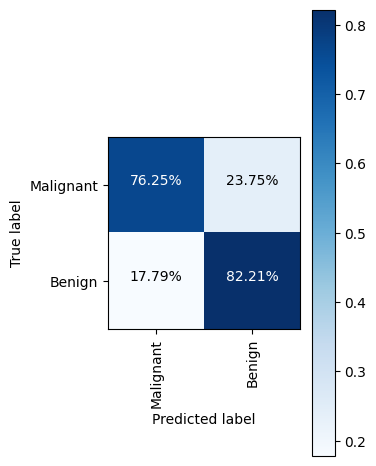

Train confusion matrix:
AUC 0.873603496216775

 Valid 


933it [01:36,  9.72it/s]


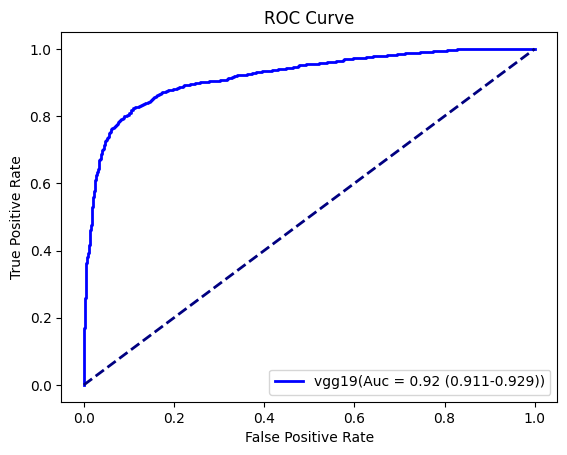

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


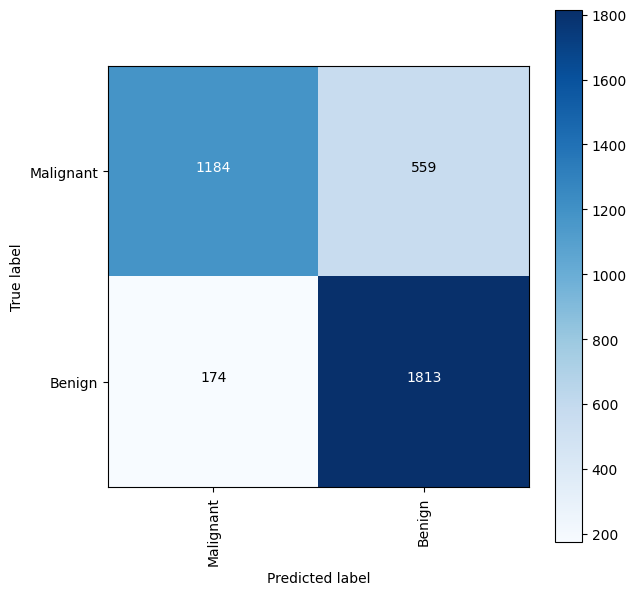

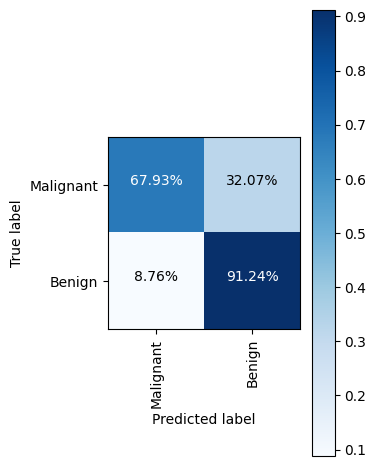

Valid confusion matrix:
AUC 0.9196123049968224
Epoch 9 with lr 0.001000000000000: t_loss: 0.4405 t_acc: 0.7954 v_loss:0.3923 v_acc: 0.8035

LYnode: t_precision: 0.8102, t_recall: 0.8221, t_F1: 0.8161
LYnode: v_precision: 0.7643, v_recall: 0.9124, v_F1: 0.8318

Epoch [10/100]

 Train 


3153it [10:35,  4.96it/s]


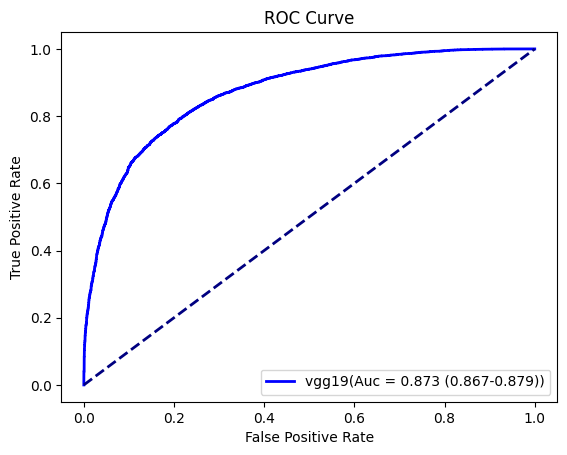

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


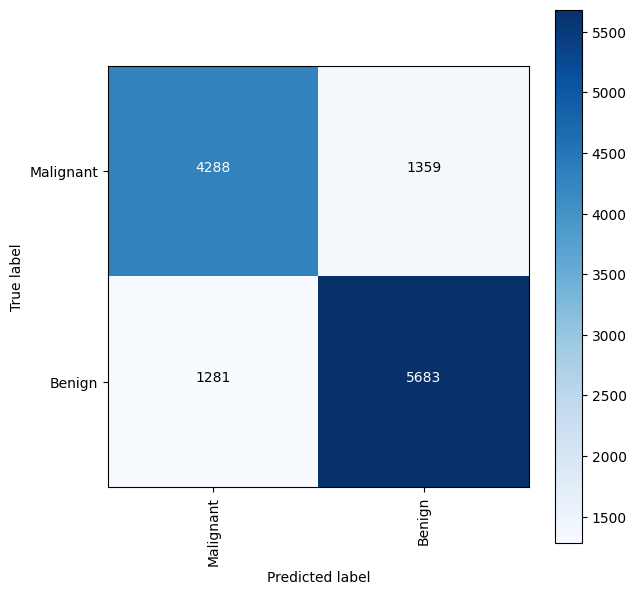

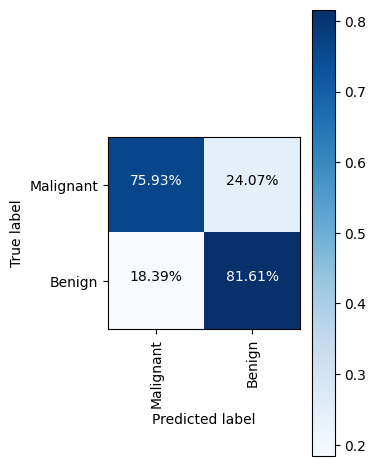

Train confusion matrix:
AUC 0.8728964777951359

 Valid 


933it [01:37,  9.61it/s]


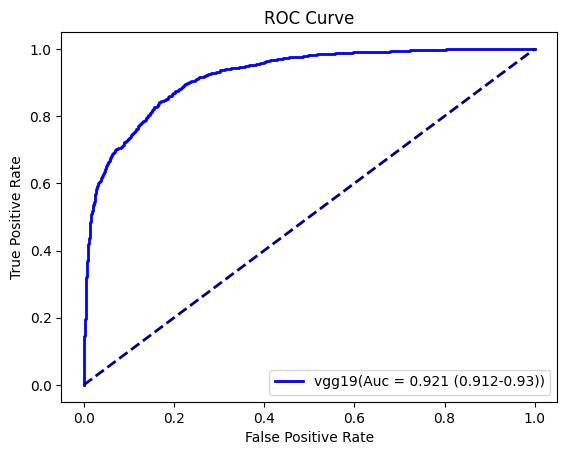

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


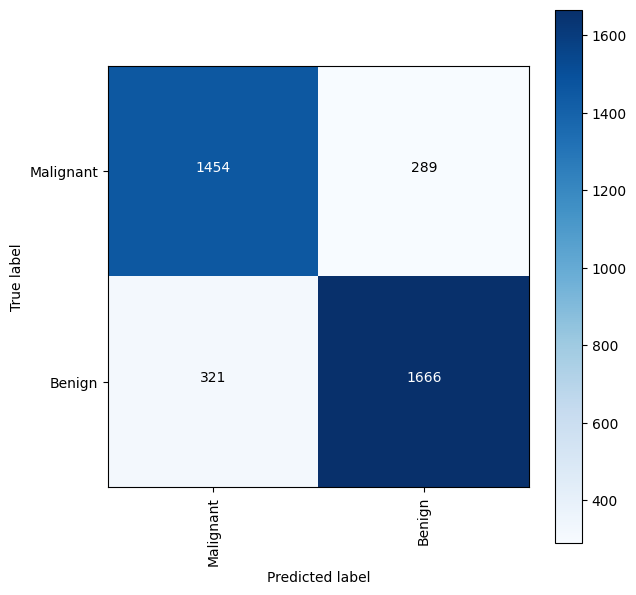

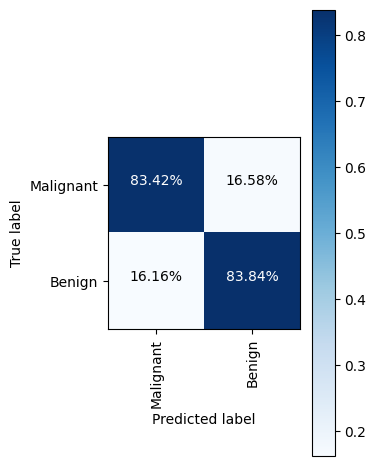

Valid confusion matrix:
AUC 0.9209601364693802
Epoch 10 with lr 0.000100000000000: t_loss: 0.4415 t_acc: 0.7907 v_loss:0.3686 v_acc: 0.8365

LYnode: t_precision: 0.8070, t_recall: 0.8161, t_F1: 0.8115
LYnode: v_precision: 0.8522, v_recall: 0.8384, v_F1: 0.8453

Epoch [11/100]

 Train 


3153it [10:46,  4.88it/s]


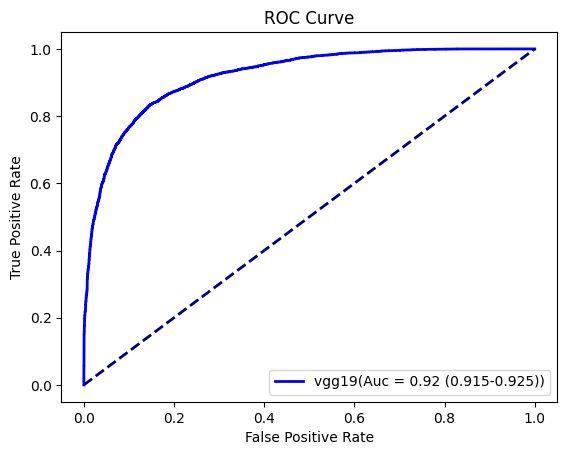

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


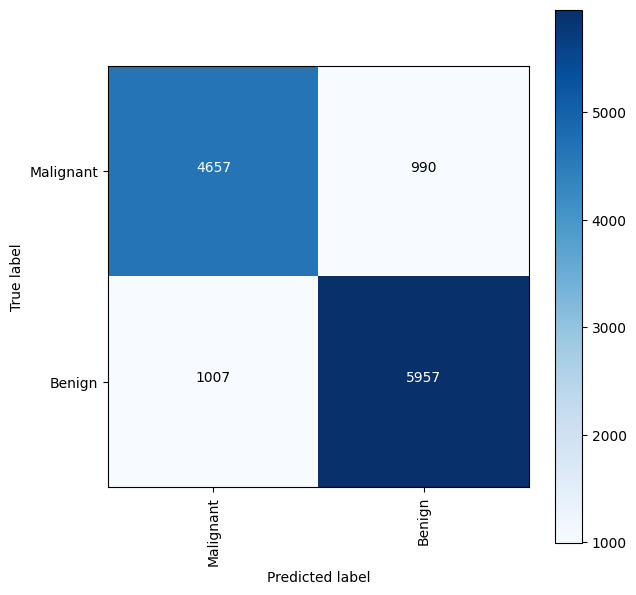

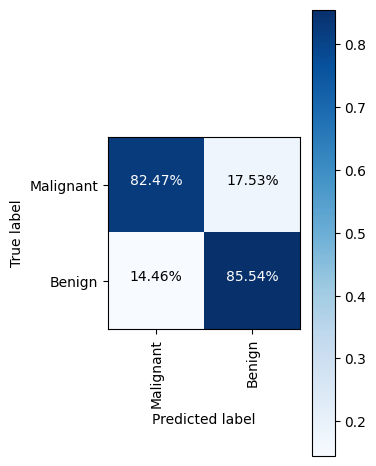

Train confusion matrix:
AUC 0.9200461947182236

 Valid 


933it [01:36,  9.67it/s]


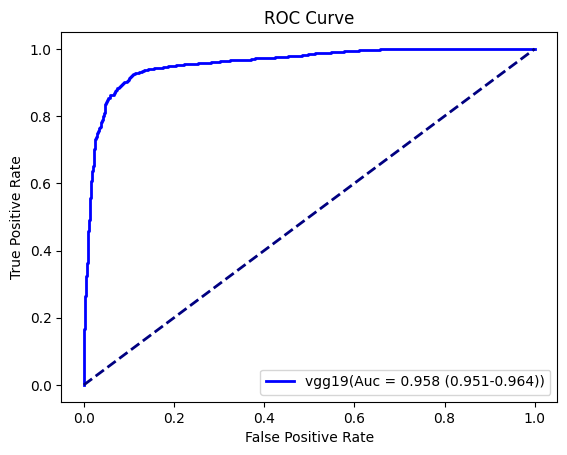

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


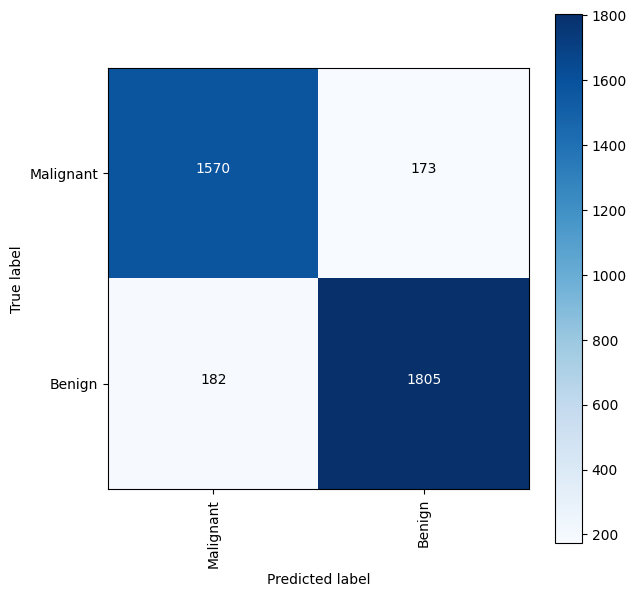

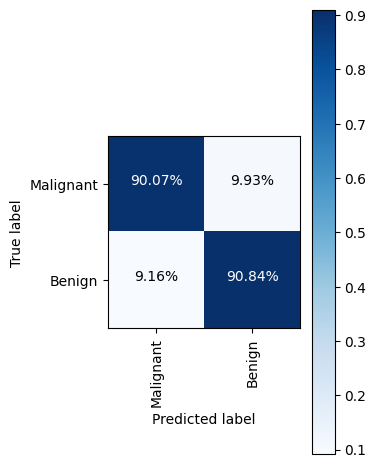

Valid confusion matrix:
AUC 0.9578923935009576
Epoch 11 with lr 0.000100000000000: t_loss: 0.3557 t_acc: 0.8416 v_loss:0.2698 v_acc: 0.9048

LYnode: t_precision: 0.8575, t_recall: 0.8554, t_F1: 0.8564
LYnode: v_precision: 0.9125, v_recall: 0.9084, v_F1: 0.9105

Epoch [12/100]

 Train 


3153it [10:43,  4.90it/s]


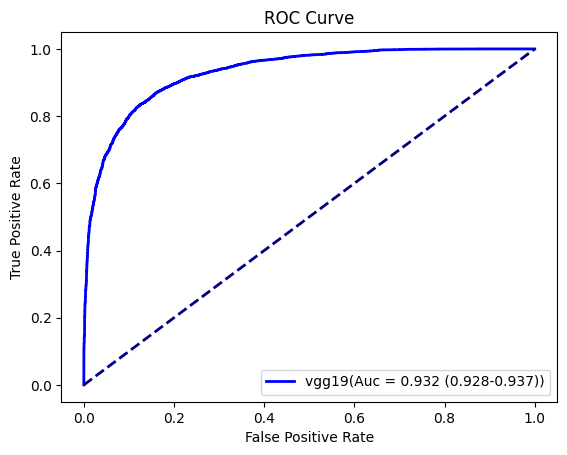

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


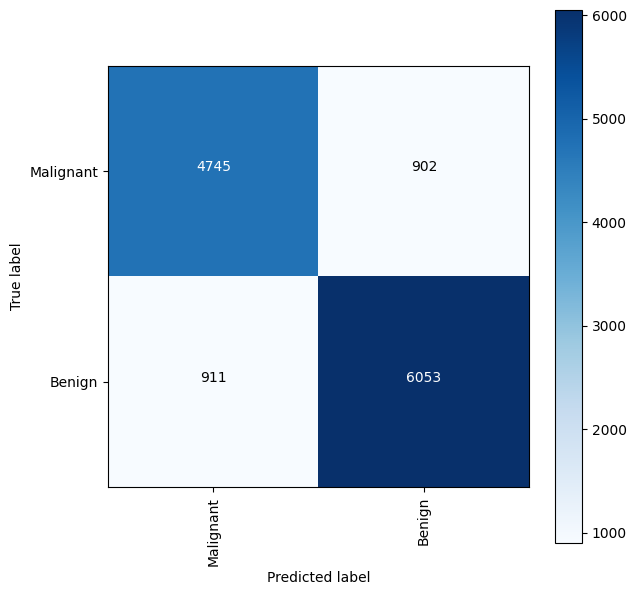

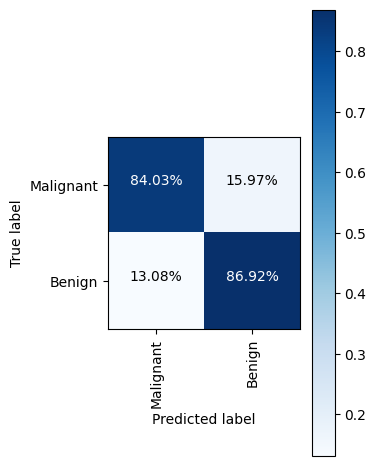

Train confusion matrix:
AUC 0.9321818948561588

 Valid 


933it [01:37,  9.59it/s]


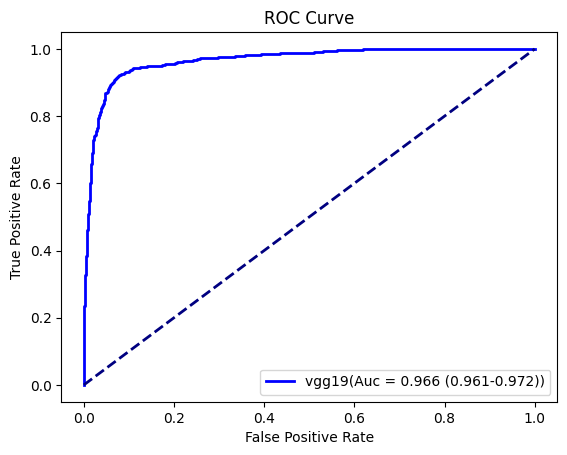

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


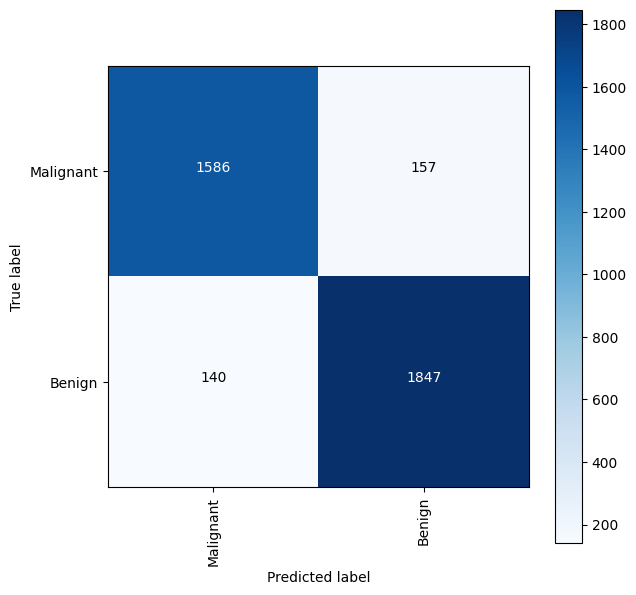

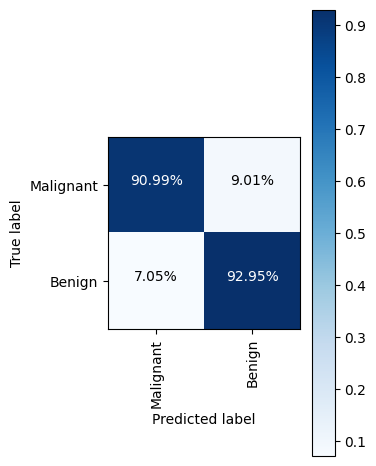

Valid confusion matrix:
AUC 0.966470526581125
Epoch 12 with lr 0.000100000000000: t_loss: 0.3286 t_acc: 0.8562 v_loss:0.2398 v_acc: 0.9204

LYnode: t_precision: 0.8703, t_recall: 0.8692, t_F1: 0.8697
LYnode: v_precision: 0.9217, v_recall: 0.9295, v_F1: 0.9256

Epoch [13/100]

 Train 


3153it [10:52,  4.83it/s]


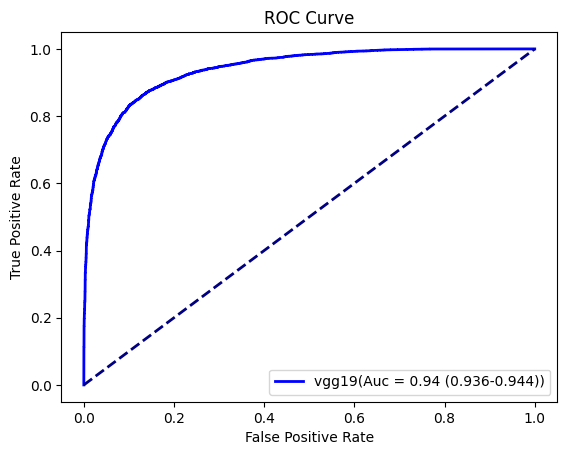

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


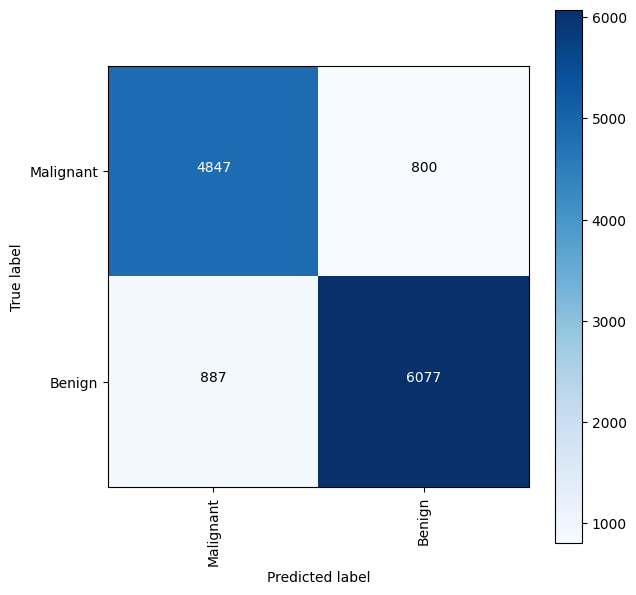

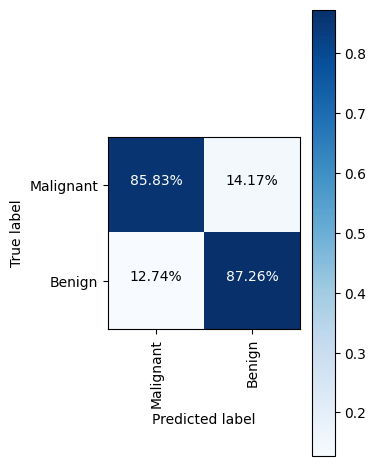

Train confusion matrix:
AUC 0.9402876103336778

 Valid 


933it [01:39,  9.41it/s]


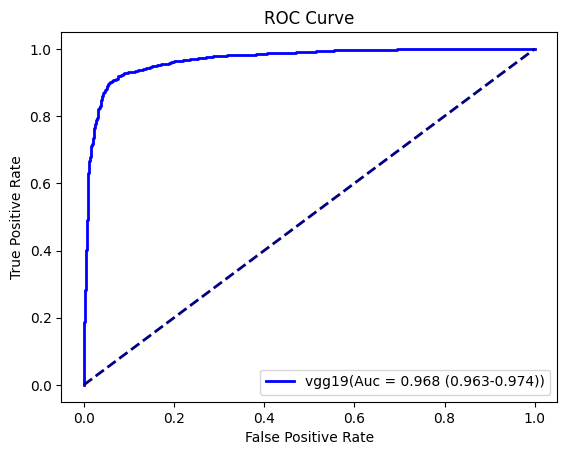

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


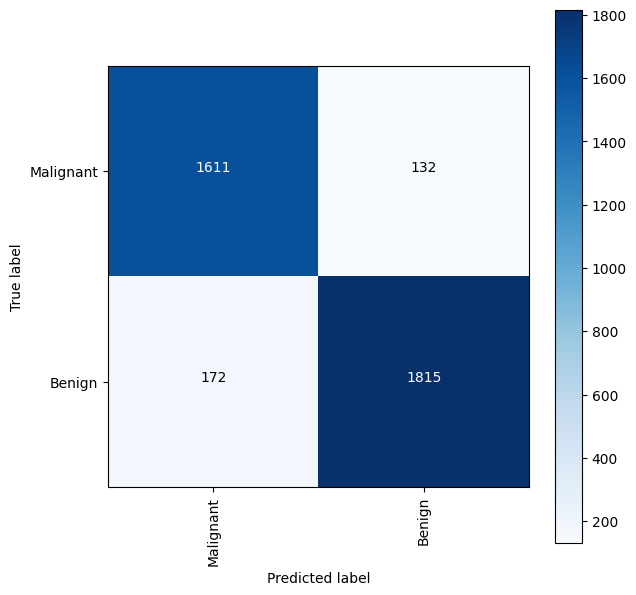

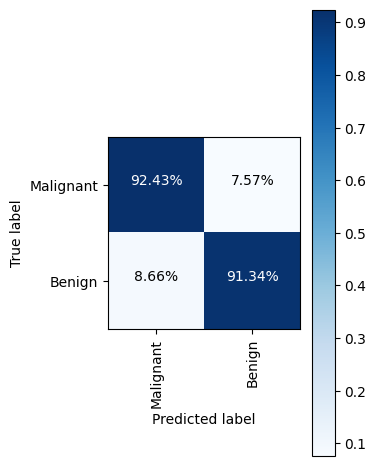

Valid confusion matrix:
AUC 0.9684238427576146
Epoch 13 with lr 0.000100000000000: t_loss: 0.3090 t_acc: 0.8662 v_loss:0.2340 v_acc: 0.9185

LYnode: t_precision: 0.8837, t_recall: 0.8726, t_F1: 0.8781
LYnode: v_precision: 0.9322, v_recall: 0.9134, v_F1: 0.9227

Epoch [14/100]

 Train 


3153it [11:02,  4.76it/s]


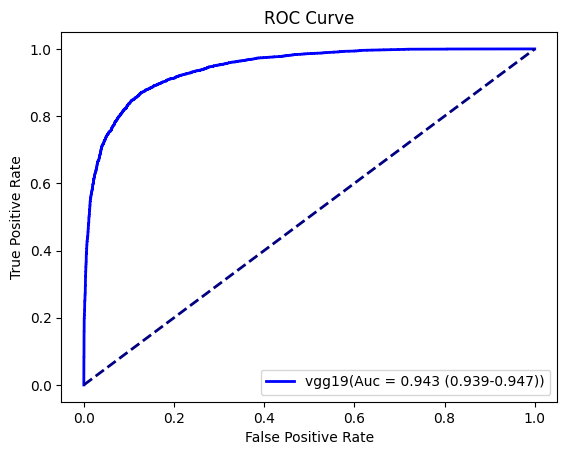

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


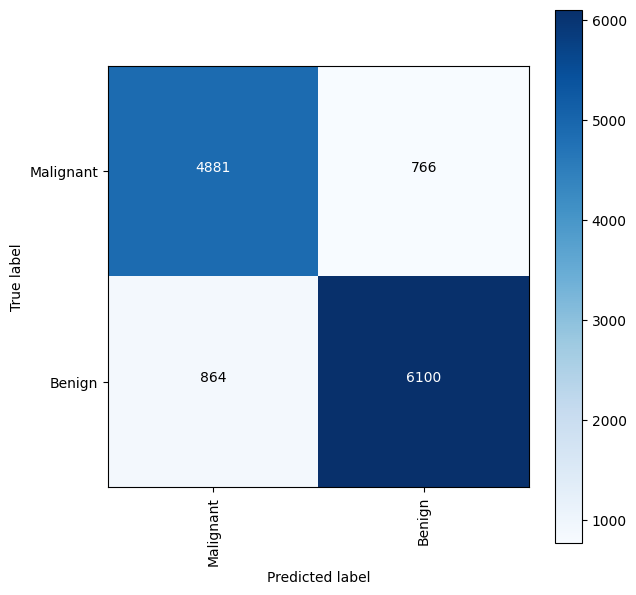

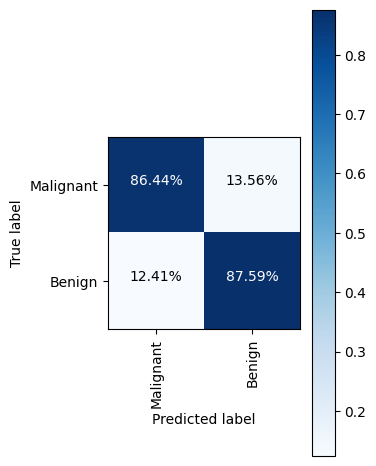

Train confusion matrix:
AUC 0.9434186410579054

 Valid 


933it [01:41,  9.19it/s]


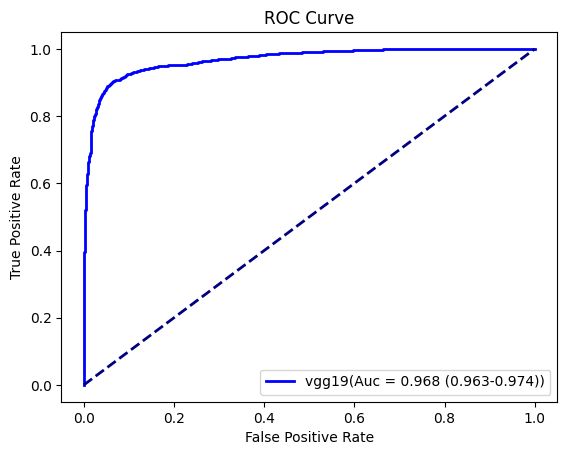

C:\Users\47872\AppData\Local\Temp\ipykernel_29236\4069014642.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, plot_index + 1)


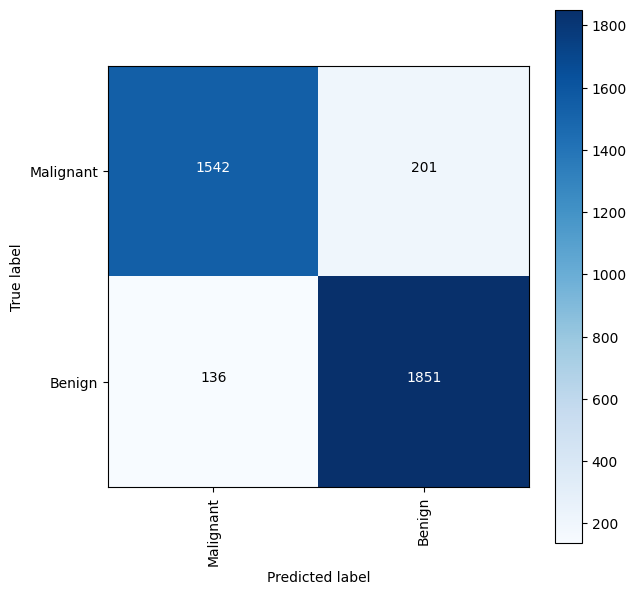

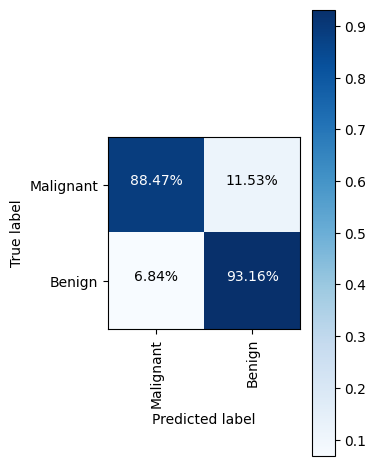

Valid confusion matrix:
AUC 0.9684726395697103
Epoch 14 with lr 0.000100000000000: t_loss: 0.3012 t_acc: 0.8707 v_loss:0.2357 v_acc: 0.9097

LYnode: t_precision: 0.8884, t_recall: 0.8759, t_F1: 0.8821
LYnode: v_precision: 0.9020, v_recall: 0.9316, v_F1: 0.9166

Epoch [15/100]

 Train 


245it [00:52,  4.67it/s]


KeyboardInterrupt: 

In [18]:
start_train(train_loader, valid_loader, model, device, criterion, optimizer, scheduler, epochs)